# **CT Scan Image Classification** 

###**Connect to Google Drive to access Dataset**


In [42]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/Colab Notebooks/Data/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/Data


### **Import Libraries**

In [43]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical


In [44]:
#define size to which images are to be resized
IMAGE_SIZE = [80, 80]

#define paths
covid_path = '/content/drive/MyDrive/Colab Notebooks/Data/COVID'
noncovid_path = '/content/drive/MyDrive/Colab Notebooks/Data/non-COVID'

# Use glob to grab images from path .jpg or jpeg
covid_files = glob(covid_path + '/*')
noncovid_files = glob(noncovid_path + '/*')


###**Resize images** 

In [45]:
covid_labels = []
noncovid_labels = []

covid_images=[]
noncovid_images=[]

for i in range(len(covid_files)):
  image = cv2.imread(covid_files[i])               # read file 
  image = cv2.resize(image,(80,80))                # resize as per model for covid 
  covid_images.append(image)                       # append image
  covid_labels.append('COVID')                     #append class label

for i in range(len(noncovid_files)):
  image = cv2.imread(noncovid_files[i])
  image = cv2.resize(image,(80,80))
  noncovid_images.append(image)
  noncovid_labels.append('non-COVID')

### **Visualize First 25 images from dataset** 

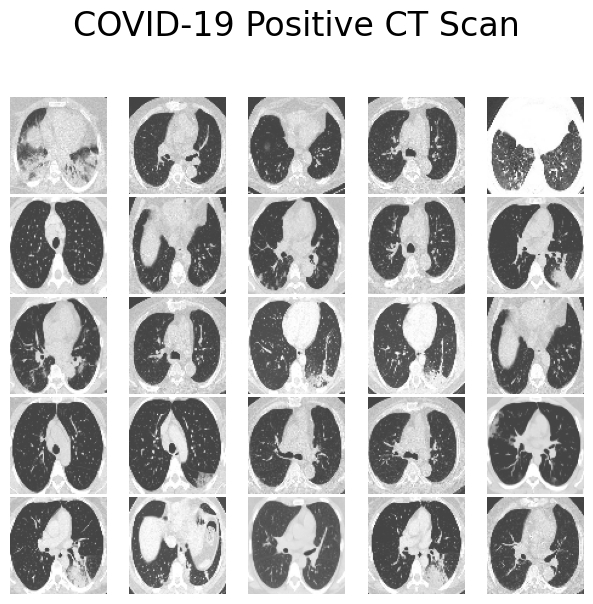

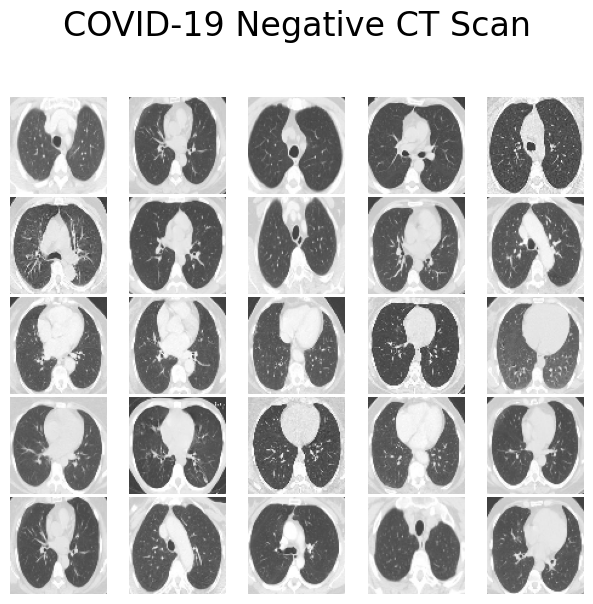

In [46]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 5
    figsize = [6, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_images, 'COVID-19 Positive CT Scan')
plot_images(noncovid_images, 'COVID-19 Negative CT Scan')

###**Normalization**


In [47]:
# Convert to array and Normalize to interval of [0,1]
covid_images = np.array(covid_images) / 255
noncovid_images = np.array(noncovid_images) / 255

###**Train Test Splitting**

In [48]:
# Split into training and testing sets for both types of images

covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_images, covid_labels, test_size=0.2, random_state=1)

noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    noncovid_images, noncovid_labels, test_size=0.2, random_state=1)

# Merge sets for both types of images
X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

# Make labels into categories - either 0 or 1, for our model
y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)
y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

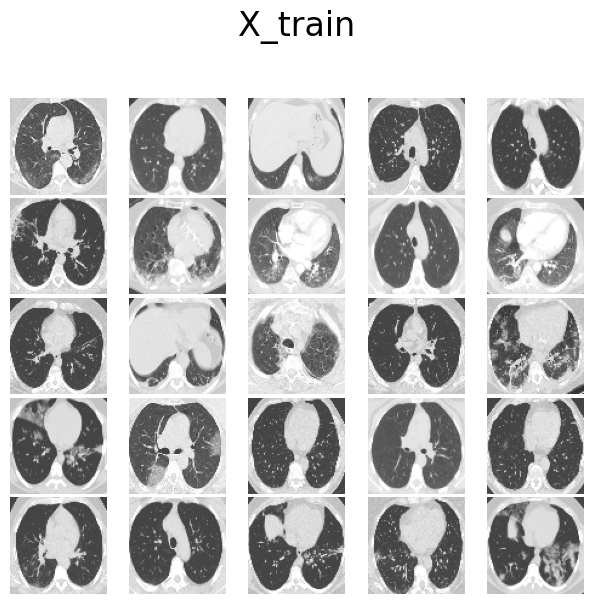

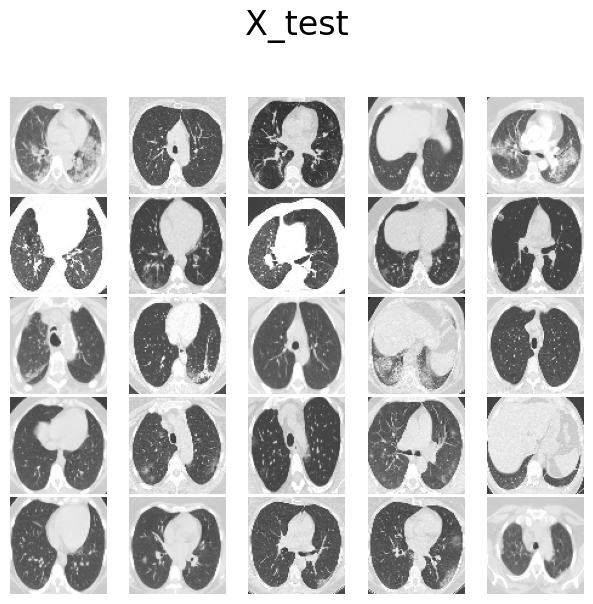

In [49]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')

###**Model Building**

In [50]:
# Building Model
from tensorflow import keras
resnet = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(80, 80, 3)))

outputs = resnet.output
outputs = Flatten(name="flatten")(outputs)
outputs = Dropout(0.3)(outputs)
outputs = Dense(2, activation="sigmoid")(outputs)

model = Model(inputs=resnet.input, outputs=outputs)

for layer in resnet.layers:
    layer.trainable = False

model.compile(
        loss='binary_crossentropy',      
        optimizer=keras.optimizers.Adamax(learning_rate=0.001), 
        metrics=['accuracy']
)
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    'model_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [51]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 86, 86, 3)    0           ['input_5[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 40, 40, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 40, 40, 64)   256         ['conv1_conv[0][0]']             
                                                                                            

###**Data Augmentation**

In [52]:
datagen = ImageDataGenerator(rotation_range=20,
  width_shift_range=0.2,
  height_shift_range=0.2,
  zoom_range=0.2,
  horizontal_flip=True
)

###**Training the Model**

In [53]:
batch_size=2
epochs=30

hist = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                  validation_data=(X_test, y_test),
                  validation_steps=len(X_test) / batch_size,
                  steps_per_epoch=len(X_train) / batch_size,
                  epochs=epochs,callbacks=[early_stopping, model_checkpoint]
                 ) 

Epoch 1/30
991/993 [============================>.] - ETA: 0s - loss: 0.6901 - accuracy: 0.6044
Epoch 1: val_loss improved from inf to 0.59253, saving model to model_checkpoint.h5
993/993 [==============================] - 23s 20ms/step - loss: 0.6897 - accuracy: 0.6047 - val_loss: 0.5925 - val_accuracy: 0.6419
Epoch 2/30
990/993 [============================>.] - ETA: 0s - loss: 0.6860 - accuracy: 0.6116
Epoch 2: val_loss did not improve from 0.59253
993/993 [==============================] - 17s 17ms/step - loss: 0.6853 - accuracy: 0.6123 - val_loss: 0.6269 - val_accuracy: 0.6519
Epoch 3/30
991/993 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.6302
Epoch 3: val_loss did not improve from 0.59253
993/993 [==============================] - 16s 16ms/step - loss: 0.6715 - accuracy: 0.6304 - val_loss: 0.8262 - val_accuracy: 0.5855
Epoch 4/30
992/993 [============================>.] - ETA: 0s - loss: 0.6733 - accuracy: 0.6280
Epoch 4: val_loss did not improve from 

In [54]:
# Save Model and Weights
model.save('resnet_ct.h5')
model.save_weights('resnet_weights_ct.hdf5')

In [55]:
# Load saved model
model = load_model('resnet_ct.h5')
final_loss, final_accuracy = model.evaluate(X_test, y_test)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy))

16/16 [==============================] - 2s 29ms/step - loss: 0.5303 - accuracy: 0.7404
Final Loss: 0.5302808880805969, Final Accuracy: 0.7404426336288452


### **Prediction**

In [56]:
y_pred = model.predict(X_test,batch_size=batch_size)

249/249 [==============================] - 4s 9ms/step


### First 10 predictions

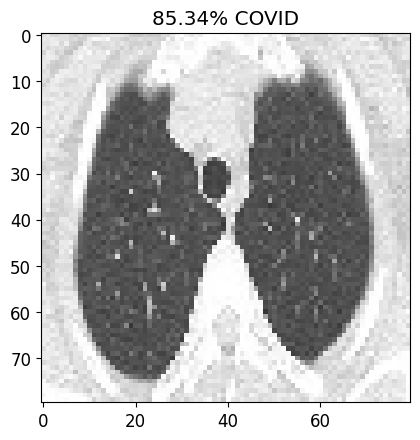

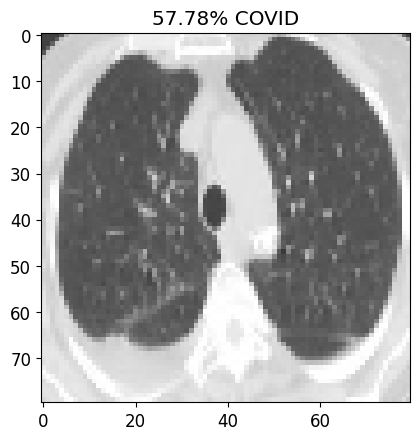

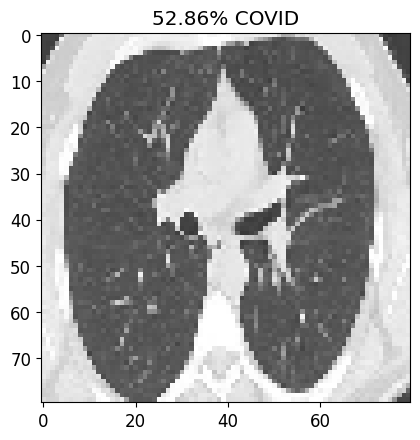

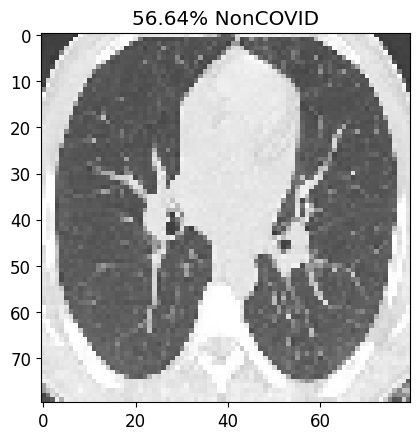

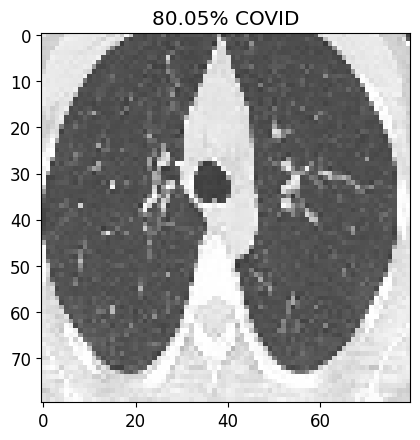

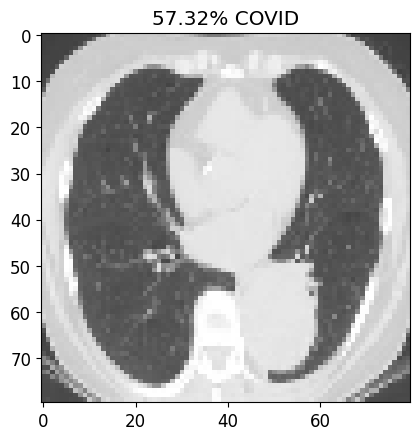

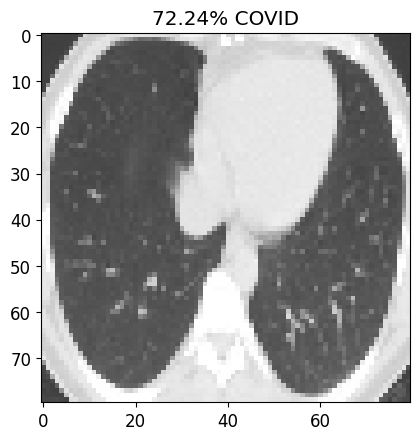

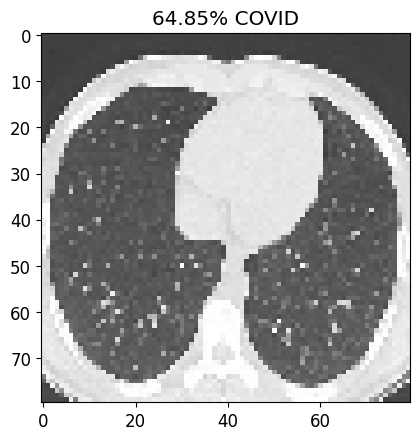

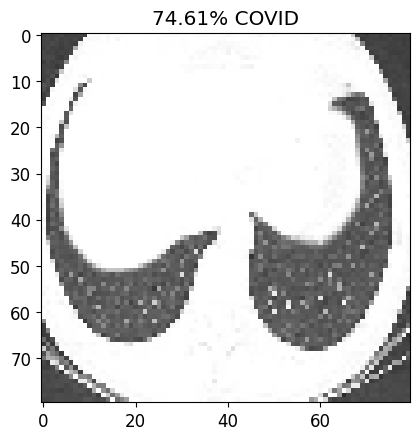

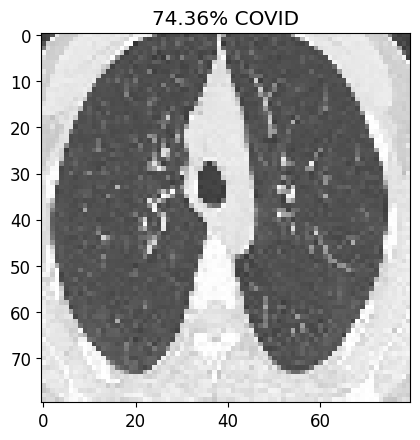

In [57]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [58]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

###**Classification Report**

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin,y_pred_bin))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75       251
           1       0.74      0.72      0.73       246

    accuracy                           0.74       497
   macro avg       0.74      0.74      0.74       497
weighted avg       0.74      0.74      0.74       497



###**Confusion Matrix**

Confusion Matrix without Normalization


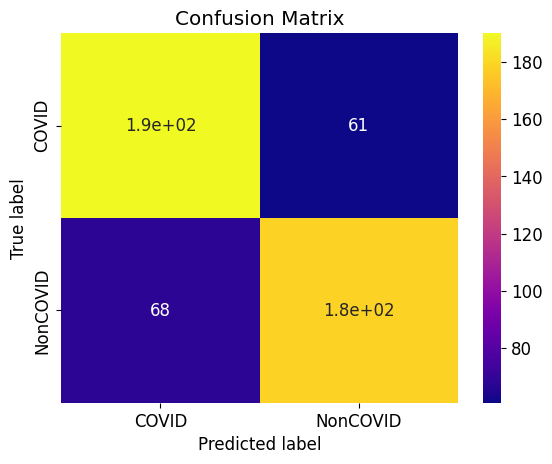

Confusion Matrix with Normalized Values


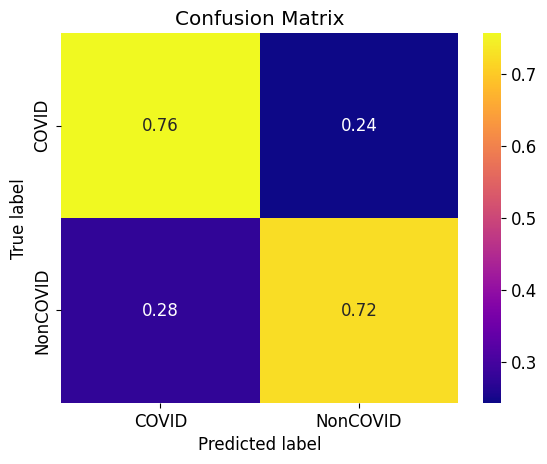

In [60]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

###**ROC Curve**

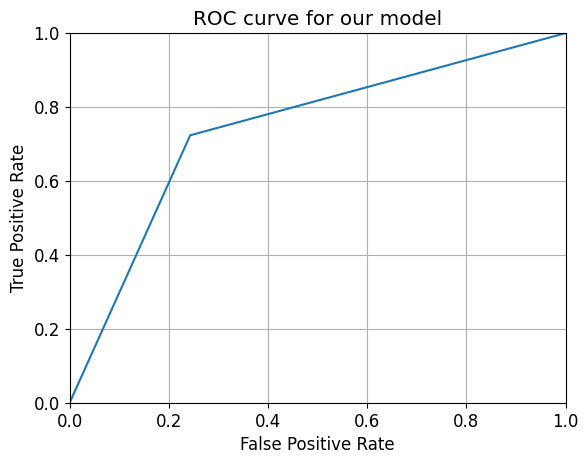

In [61]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

**Model Accuracy Plot**

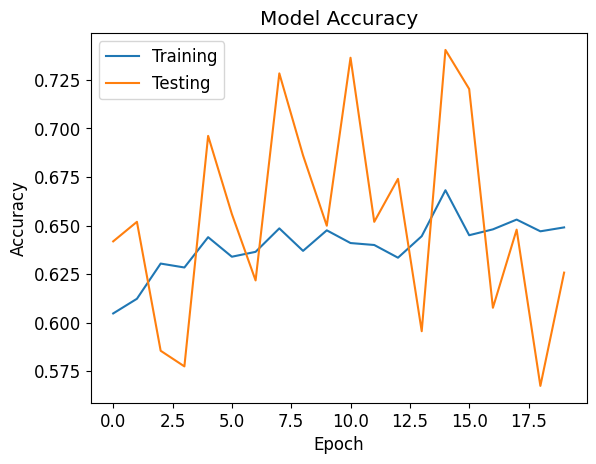

In [62]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_accuracy.png')
plt.show()


**Model Loss Plot**

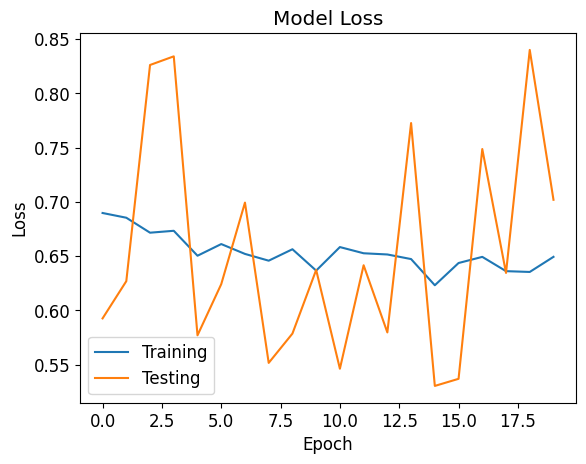

In [63]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_loss.png')
plt.show()